# Study of Image classification with modern MLP Mixer model and CKA

**Author:** [Arturo Flores](https://www.linkedin.com/in/afloresalv/)<br>
**Based on (MLP-MIXER):**  https://keras.io/examples/vision/mlp_image_classification/

## Introduction
#####################


This example implements three modern attention-free, multi-layer perceptron (MLP) based models for image
classification, demonstrated on the CIFAR-100 dataset:

1. The [MLP-Mixer](https://arxiv.org/abs/2105.01601) model, by Ilya Tolstikhin et al., based on two types of MLPs.

The purpose of the example is not to compare between these models, as they might perform differently on
different datasets with well-tuned hyperparameters. Rather, it is to show simple implementations of their
main building blocks.

This example requires TensorFlow 2.4 or higher, as well as
[TensorFlow Addons](https://www.tensorflow.org/addons/overview),
which can be installed using the following command:

```shell
pip install -U tensorflow-addons
update tensorflow core to 2.7.0
```

# Setup for the MLP-Mixer Architecture

################################################################

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_addons as tfa
import matplotlib.pyplot as plt 

D:\Program_Files\Anaconda3\envs\AI\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:67: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.5.0 and strictly below 2.8.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.8.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  UserWarning,


## Prepare the data
C1FAR 100 = 100 classes, each 600 images

In [2]:
num_classes = 100
input_shape = (32, 32, 3)

(x_train, y_train), (x_test, y_test) = keras.datasets.cifar100.load_data()

print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")
#plt.imshow(x_train[1])

x_train shape: (50000, 32, 32, 3) - y_train shape: (50000, 1)
x_test shape: (10000, 32, 32, 3) - y_test shape: (10000, 1)


## Configure the hyperparameters

In [3]:
weight_decay = 0.0001
batch_size = 128 # The paper also fine tunes this to 512
num_epochs = 20
dropout_rate = 0.2
image_size = 64  # We'll resize input images to this size. Square
patch_size = 8  # Size of the patches to be extracted from the input images. Square
num_patches = (image_size // patch_size) ** 2  # Size of the data array, or sequence length (S)
embedding_dim = 256  # Number of hidden units.
num_blocks = 4  # Number of Mixer Layers
num_example = 13

print(f"Image size: {image_size} X {image_size} = {image_size ** 2}")
print(f"Patch size: {patch_size} X {patch_size} = {patch_size ** 2} ")
print(f"Patches per image: {num_patches}")
print(f"Elements per patch (3 channels): {(patch_size ** 2) * 3}")

Image size: 64 X 64 = 4096
Patch size: 8 X 8 = 64 
Patches per image: 64
Elements per patch (3 channels): 192


## Build a classification model

We implement a method that builds a classifier given the processing blocks. \
Positional Encoding = https://kazemnejad.com/blog/transformer_architecture_positional_encoding/  


In [4]:

def build_classifier(blocks, positional_encoding=False):
    inputs = layers.Input(shape=input_shape)
    # Augment data. 
    augmented = data_augmentation(inputs)
    # Create patches. 
    patches = Patches(patch_size, num_patches)(augmented)
    # Encode patches to generate a [batch_size, num_patches, embedding_dim] tensor.
    x = layers.Dense(units=embedding_dim)(patches)
    if positional_encoding:
        positions = tf.range(start=0, limit=num_patches, delta=1)
        position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=embedding_dim
        )(positions)
        x = x + position_embedding
    # Process x using the module blocks. ## (sequential_82)
    x = blocks(x)
    # Apply global average pooling to generate a [batch_size, embedding_dim] representation tensor. 
    representation = layers.GlobalAveragePooling1D()(x)
    # Apply dropout.
    representation = layers.Dropout(rate=dropout_rate)(representation)
    # Compute logits outputs.
    logits = layers.Dense(num_classes)(representation) 
    # Create the Keras model.
    return keras.Model(inputs=inputs, outputs=logits)


## Define an experiment

We implement a utility function to compile, train, and evaluate a given model. \
Adam Algorithm with Weight Decay: https://www.tensorflow.org/addons/api_docs/python/tfa/optimizers/AdamW \
Losses: https://keras.io/api/losses/ \
Reduce learning rate: https://keras.io/api/callbacks/reduce_lr_on_plateau/ \
Logits: https://www.youtube.com/watch?v=icQaFxKa_J0


In [5]:

def run_experiment(model):
    # Create Adam optimizer with weight decay. Regularization that penalizes the increase of weight - with a facto alpha - to correct the overfitting
    optimizer = tfa.optimizers.AdamW(
        learning_rate=learning_rate, weight_decay=weight_decay,
    )
    # Compile the model.
    model.compile(
        optimizer=optimizer,
        #Negative Log Likelihood = Categorical Cross Entropy
        loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[
            keras.metrics.SparseCategoricalAccuracy(name="acc"),
            keras.metrics.SparseTopKCategoricalAccuracy(5, name="top5-acc"),
        ],
    )
    # Create a learning rate scheduler callback.
    reduce_lr = keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=5
    )
    # Create an early stopping regularization callback. 
    # It ends at a point that corresponds to a minimum of the L2-regularized objective
    early_stopping = tf.keras.callbacks.EarlyStopping(
        monitor="val_loss", patience=10, restore_best_weights=True
    )
    # Fit the model.
    history = model.fit(
        x=x_train,
        y=y_train,
        batch_size=batch_size,
        epochs=num_epochs,
        validation_split=0.1,
        callbacks=[early_stopping, reduce_lr],
    )

    _, accuracy, top_5_accuracy = model.evaluate(x_test, y_test)
    print(f"Test accuracy: {round(accuracy * 100, 2)}%")
    print(f"Test top 5 accuracy: {round(top_5_accuracy * 100, 2)}%")

    # Return history to plot learning curves.
    return history


## Use data augmentation
Their state is not set during training; it must be set before training, either by initializing them from a precomputed constant, or by "adapting" them on data.

In [6]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.Resizing(image_size, image_size),
        layers.RandomFlip("horizontal"),
        layers.RandomZoom(
            height_factor=0.2, width_factor=0.2
        ),
    ],
    name="data_augmentation",
)
# Compute the mean and the variance of the training data for normalization.
data_augmentation.layers[0].adapt(x_train)


## Implement patch extraction as a layer
Atributes and heritage: https://pythones.net/funcion-super-en-python-bien-explicada-ejemplos-oop/ \
Extract Patches: https://www.tensorflow.org/api_docs/python/tf/image/extract_patches \
Reshape: https://www.tensorflow.org/api_docs/python/tf/reshape \
If one component of shape is the special value -1, the size of that dimension is computed so that the total size remains constant. \
Preprocessing data: https://www.tensorflow.org/guide/keras/preprocessing_layers

In [7]:

class Patches(layers.Layer):
    def __init__(self, patch_size, num_patches):
        super(Patches, self).__init__()
        self.patch_size = patch_size
        self.num_patches = num_patches

    def call(self, images):
        #Extract the shape dimension in the position 0 = columns
        batch_size = tf.shape(images)[0]
        patches = tf.image.extract_patches(
            images=images,
            sizes=[1, self.patch_size, self.patch_size, 1],
            #Without overlapping, stride horizontally and vertically
            strides=[1, self.patch_size, self.patch_size, 1],
            #Rate: Dilation factor [1 1* 1* 1] controls the spacing between the kernel points.
            rates=[1, 1, 1, 1],
            #Patches contained in the images are considered, no zero padding
            padding="VALID",
        )
        #shape[-1], number of colummns, as well as shape[0]
        patch_dims = patches.shape[-1]
        patches = tf.reshape(patches, [batch_size, self.num_patches, patch_dims])
        return patches


## The MLP-Mixer model

The MLP-Mixer is an architecture based exclusively on
multi-layer perceptrons (MLPs), that contains two types of MLP layers:

1. One applied independently to image patches, which mixes the per-location features.
2. The other applied across patches (along channels), which mixes spatial information.

This is similar to a [depthwise separable convolution based model](https://arxiv.org/pdf/1610.02357.pdf)
such as the Xception model, but with two chained dense transforms, no max pooling, and layer normalization
instead of batch normalization.

### Implement the MLP-Mixer module

In [8]:

class MLPMixerLayer(layers.Layer):
    def __init__(self, num_patches, hidden_units, dropout_rate, *args, **kwargs):
        super(MLPMixerLayer, self).__init__(*args, **kwargs)

        self.mlp1 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=num_patches),
                layers.Dropout(rate=dropout_rate),
            ]
        )

        self.mlp2 = keras.Sequential(
            [
                layers.Dense(units=num_patches),
                tfa.layers.GELU(),
                layers.Dense(units=embedding_dim),
                layers.Dropout(rate=dropout_rate),
            ]
        )
        self.normalize = layers.LayerNormalization(epsilon=1e-6)

    def call(self, inputs):
        # Apply layer normalization.
        x = self.normalize(inputs)
        # Transpose inputs from [num_batches, num_patches, hidden_units] to [num_batches, hidden_units, num_patches].
        x_channels = tf.linalg.matrix_transpose(x)
        # Apply mlp1 on each channel independently.
        mlp1_outputs = self.mlp1(x_channels)
        # Transpose mlp1_outputs from [num_batches, hidden_dim, num_patches] to [num_batches, num_patches, hidden_units].
        mlp1_outputs = tf.linalg.matrix_transpose(mlp1_outputs)
        # Add skip connection.
        x = mlp1_outputs + inputs
        # Apply layer normalization.
        x_patches = self.normalize(x)
        # Apply mlp2 on each patch independtenly.
        mlp2_outputs = self.mlp2(x_patches)
        # Add skip connection.
        x = x + mlp2_outputs
        return x

## Build, train, and evaluate the MLP-Mixer model

Note that training the model with the current settings on a V100 GPUs
takes around 8 seconds per epoch.

In [9]:
# Report: Learning Curve
def curves(histories):
    ymax1 = min(history.history["loss"])
    xmax1 = history.history["loss"].index(ymax1)
    ymax2 = min(history.history["val_loss"])
    xmax2 = history.history["val_loss"].index(ymax2)
    plt.title("Cross Entropy Loss")
    plt.plot(histories.history["loss"], color = 'blue', label = 'Training')
    plt.plot(histories.history["val_loss"], color = 'orange', label = 'Testing')
    plt.xlabel("Epochs")
    plt.annotate('Max:' + str(round(ymax1,2)) , xy = (xmax1, ymax1), xytext = (xmax1*0.93, 1.07*ymax1), 
                    arrowprops=dict(facecolor='blue', headwidth= 6, headlength =9))
    plt.annotate('Max:' + str(round(ymax2,2)) , xy = (xmax2, ymax2), xytext = (xmax2*0.93, 1.07*ymax2), 
                    arrowprops=dict(facecolor='goldenrod', headwidth= 6, headlength =9))
    plt.xlim([0,num_epochs])
    plt.legend()
    plt.show()
    # Graph accuracy
    ymax3 = max(history.history["acc"])
    xmax3 = history.history["acc"].index(ymax3)
    ymax4 = max(history.history["val_acc"])
    xmax4 = history.history["val_acc"].index(ymax4)
    ymax5 = max(history.history["top5-acc"])
    xmax5 = history.history["top5-acc"].index(ymax5)
    ymax6 = max(history.history["val_top5-acc"])
    xmax6 = history.history["val_top5-acc"].index(ymax6)
    plt.subplot(2,1,1)
    plt.title('Classification accuracy')
    plt.plot(histories.history['acc'], color = 'blue', label = 'Training')
    plt.plot(histories.history['val_acc'], color = 'orange', label = 'Testing')
    plt.annotate('Max:' + str(round(ymax3,2)) , xy = (xmax3, ymax3), xytext = (xmax3*0.93, 1.2*ymax3), 
                    arrowprops=dict(facecolor='blue', headwidth= 6, headlength =9))
    plt.annotate('Max:' + str(round(ymax4,2)) , xy = (xmax4, ymax4), xytext = (xmax4*0.93, 0.7*ymax4), 
                    arrowprops=dict(facecolor='goldenrod', headwidth= 6, headlength =9))
    plt.subplot(2,1,2)
    plt.title('Classification top5-acc')
    plt.plot(histories.history['top5-acc'], color = 'blue', label = 'Training')
    plt.plot(histories.history['val_top5-acc'], color = 'orange', label = 'Testing')
    plt.annotate('Max:' + str(round(ymax5,2)) , xy = (xmax5, ymax5), xytext = (xmax5*0.93, 1.2*ymax5), 
                    arrowprops=dict(facecolor='blue', headwidth= 6, headlength =9))
    plt.annotate('Max:' + str(round(ymax6,2)) , xy = (xmax6, ymax6), xytext = (xmax6*0.87, 1.2*ymax6), 
                    arrowprops=dict(facecolor='goldenrod', headwidth= 6, headlength =9))
    plt.xlim([0,num_epochs])
    plt.xlabel("Epochs")
    plt.suptitle("Learning Curves")
    plt.legend()
    plt.tight_layout()
    plt.show()

In [10]:
mlpmixer_blocks = keras.Sequential(
    [MLPMixerLayer(num_patches, embedding_dim, dropout_rate) for _ in range(num_blocks)] # creates the number of block without a 
)
learning_rate = 0.005
mlpmixer_classifier = build_classifier(mlpmixer_blocks) # Returns the model

# Before Training (bt)
############################

The MLP-Mixer model tends to have much less number of parameters compared
to convolutional and transformer-based models, which leads to less training and
serving computational cost.

As mentioned in the [MLP-Mixer](https://arxiv.org/abs/2105.01601) paper,
when pre-trained on large datasets, or with modern regularization schemes,
the MLP-Mixer attains competitive scores to state-of-the-art models.
You can obtain better results by increasing the embedding dimensions,
increasing the number of mixer blocks, and training the model for longer.
You may also try to increase the size of the input images and use different patch sizes.

## Visualization of activations of each MLP-Mixer block 

In [11]:
def visualize_out(result,layer_number,example):
    fig, (ax1, ax2)= plt.subplots(1,2)
    ax1.imshow(x_train[example])
    ax1.set_title('Original_Figure, Class: #' + str(y_train[example][0]))
    ax2.imshow(result[layer_number])
    ax2.set_title('Activations of MLP block of the Mixer #: '+ '"' + str(layer_number) + '"')
    return None

In [12]:
# Preprocessing Layers + Patches + One dense layer
def Preprocessing(num_example):
    augmented = data_augmentation(x_train[num_example])
    b = Patches(patch_size, num_patches)(augmented)
    a = layers.Dense(units=embedding_dim)(b)
    inp = tf.reshape(a,[1,embedding_dim,num_patches])
    return inp

In [13]:
## Computes the outputs of each MLP-mixer Layer
def Mixer_Activations(example):
    total_activations = list()
    for i in range(num_blocks):
        model_output = mlpmixer_classifier.layers[4].layers[i]
        int_total_activations = Mixer_Layer_Outputs(model_output,example)
        total_activations.append(int_total_activations)
    return  total_activations

In [14]:
def Mixer_Layer_Outputs(model,example):
    #The input is fixed to the beginning of the mlp blocks
    inputs = mlpmixer_classifier.layers[4].layers[0].input
    intermediate_model=tf.keras.models.Model(inputs=inputs,outputs=model.output)
    #This reshape is necessary for the input of the model
    example = tf.reshape(example,[1,num_patches,embedding_dim])
    #Inference
    intermediate_prediction =intermediate_model.predict(example)
    #This reshape is standardize the output
    layactivation = intermediate_prediction.reshape((embedding_dim,num_patches))
    return layactivation

In [15]:
#Run once to avoid randomness
example_prepro = Preprocessing(num_example)

### Random Sample - Visualization

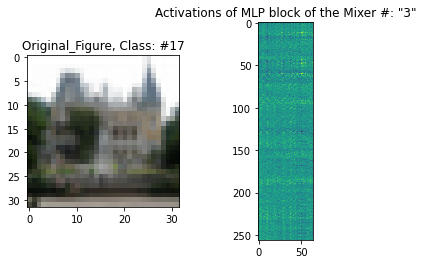

In [16]:
#Select a MixerBlock and visualize the activation
n_MixerLayer = 3
bt_result = Mixer_Activations(example_prepro)
visualize_out(bt_result,n_MixerLayer,num_example)

## CKA Kernel
### Setup additional libraries

Selected GitHub: https://github.com/yuanli2333/CKA-Centered-Kernel-Alignment/blob/master/CKA.ipynb \
GitHub2: https://github.com/jayroxis/CKA-similarity/blob/main/CKA.ipynb \
Paper: https://arxiv.org/pdf/1905.00414.pdf

In [17]:
# Files imported from the sleected GitHub
from CKA import linear_CKA, kernel_CKA
import seaborn as sns 

In [18]:
# Calculates a heatmap according to the selection of a CKA_Kernel (preferred) or CKA_Linear
def Heatmap(result,type):
    dim = len(result)
    heatmap_CKA = np.zeros((dim,dim))
    for i in range(0,dim):
        for j in range(0,dim):
            if type == 'kernel':
                heatmap_CKA[i][j] = kernel_CKA(result[i],result[j])
            elif type == 'linear':
                heatmap_CKA[i][j] = linear_CKA(result[i],result[j])  
            else:
                print('There is no such category, try again')
                break
    #print('CKA' + type + 'calculated')
    return heatmap_CKA

In [19]:
# Outputs an image of the heatmap
def visualize_Heatmap(heatmap,type,bl):
    if type == 'kernel' or type == 'linear':
        dim = len(heatmap)
        axis_labels = list()
        for i in range(0,dim):
            axis_labels_inter = str('L%i'%(i+1))
            axis_labels.append(axis_labels_inter)
        _,ax = plt.subplots(figsize=(10,10))
        ax.set_title('Similarity Measures - Index: CKA-'+ type)
        sns.heatmap(heatmap, xticklabels=axis_labels, yticklabels=axis_labels, ax = ax, annot=bl)
        sns.set(font_scale=1.5)
        ax.set_xlabel('L=# MixerLayer')
        plt.savefig('CKA_'+ type +'.png', dpi=300)
    else:
        print('There is no such category, try again')


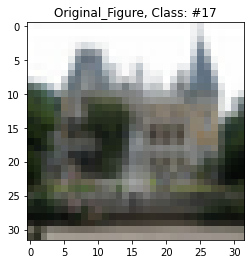

In [20]:
# Random sample
ax1 = plt.axes()
ax1.set_title('Original_Figure, Class: #' + str(y_train[num_example][0]))
plt.imshow(x_train[num_example])


### Result: Random Sample - Heatmap

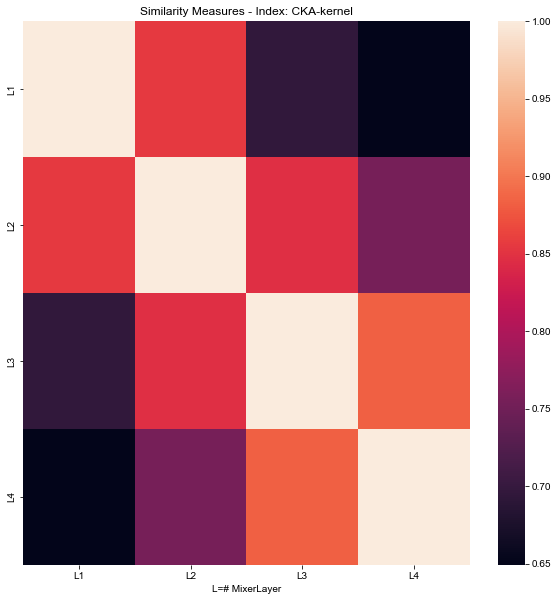

In [21]:
## Heatmap of activations of the random sample
bt_heatmap_CKA_ran = Heatmap(bt_result,'kernel')
visualize_Heatmap(bt_heatmap_CKA_ran,'kernel',False)

## CKA Kernel for a Batch


In [22]:
import random

In [23]:
# Creates a random vector with indexes of a random batch selection and also regularizes the selected batch
def Batch_Preprocessing(batch_size):
    #Vector with the number of Sample of the Xtrain
    a  = list(range(0,x_train.shape[0]))
    b = random.sample(a,batch_size)
    batch_regularization = list()
    for i in range(0,batch_size):
        inter_result = Preprocessing(b[i])
        batch_regularization.append(inter_result)
    return batch_regularization


In [24]:
#Average of layer's activation
def Prom_Mixer_Activations_Blocks(batch_regularization):
    sum = list()
    for i in range(0,num_blocks):
        sum_raw = np.zeros((embedding_dim,num_patches))
        sum.append(sum_raw)
    for i in range(0,batch_size):
        mixer_raw = Mixer_Activations(batch_regularization[i])
        for i in range(0,num_blocks):
            sum[i] = np.add(mixer_raw[i],sum[i])
    prom_mixer_activations = [ (number / batch_size)  for number in sum]
    return prom_mixer_activations

In [25]:
#Average of heatmaps (obsolet)
def Prom_Mixer_Heatmaps(batch_result,type):
    mat_heatmaps = list()
    prom_mixer_heatmap_raw = np.zeros((num_blocks,num_blocks))
    for i in range(0,batch_size):
        mixer_activations_raw = Mixer_Activations(batch_result[i])
        heatmap_raw = Heatmap(mixer_activations_raw, type)
        mat_heatmaps.append(heatmap_raw)
        prom_mixer_heatmap_raw = np.add(heatmap_raw,prom_mixer_heatmap_raw)
    prom_mixer_heatmap =  prom_mixer_heatmap_raw/batch_size  
    return prom_mixer_heatmap,mat_heatmaps
        

In [26]:
#Run separtely to avoid randomness 
batch_prepro = Batch_Preprocessing(batch_size)

### Result: Batch - Heatmap

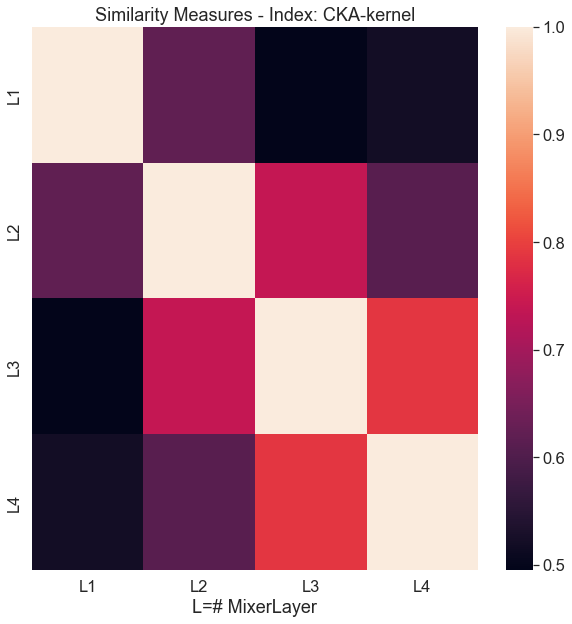

In [27]:
#Average of layer's activation
bt_ave_mixer_activations = Prom_Mixer_Activations_Blocks(batch_prepro)
bt_global_heatmap = Heatmap(bt_ave_mixer_activations,'kernel')
visualize_Heatmap(bt_global_heatmap,'kernel',False)

## Stadistics of the Activations

In [28]:
from scipy.stats import norm
from matplotlib.ticker import FormatStrFormatter

In [29]:
#Second Argument displays the mean, and the standard deviation 
def Distribution_Act_Layers(result,flag):
    legends = list()
    fig, ax = plt.subplots()
    for i in range(num_blocks):
        x = result[i].flatten(order='C')
        mu, std = norm.fit(x)
        x = np.linspace(x.min(), x.max(), 200)
        p = norm.pdf(x, mu, std)
        ax.plot(x, p*100, linewidth=2)
        if flag:
            legends_i = str('L' + str(i+1) + r'$, \mu=$' + str(round(mu,2)) + r'$, \sigma=$' + str(round(std,2)))
        else:
            legends_i = str('L' + str(i+1))
        legends.append(legends_i)
    ax.set_title('Distribution of Activations for each Layer')
    ax.legend(legends, fontsize ='small', fancybox = True)
    ax.set_xlabel('Value')
    ax.set_ylabel('Relative Frequency (%)')
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))

### Data distribution of Activations

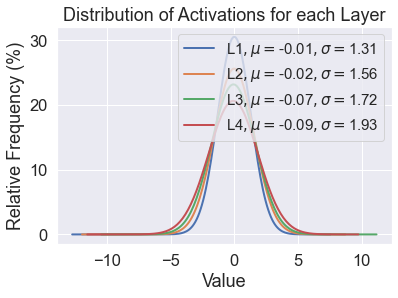

In [30]:
Distribution_Act_Layers(bt_result,True)

# After Training (at)
###############################

In [31]:
history = run_experiment(mlpmixer_classifier)

Epoch 1/20
352/352 [==============================] - 59s 151ms/step - loss: 3.8477 - acc: 0.1130 - top5-acc: 0.3242 - val_loss: 3.5992 - val_acc: 0.1602 - val_top5-acc: 0.4174 - lr: 0.0050
Epoch 2/20
352/352 [==============================] - 53s 149ms/step - loss: 3.3544 - acc: 0.1934 - top5-acc: 0.4674 - val_loss: 3.2290 - val_acc: 0.2318 - val_top5-acc: 0.5044 - lr: 0.0050
Epoch 3/20
352/352 [==============================] - 52s 147ms/step - loss: 3.1809 - acc: 0.2267 - top5-acc: 0.5114 - val_loss: 3.0285 - val_acc: 0.2614 - val_top5-acc: 0.5584 - lr: 0.0050
Epoch 4/20
352/352 [==============================] - 52s 149ms/step - loss: 3.0128 - acc: 0.2565 - top5-acc: 0.5573 - val_loss: 2.9894 - val_acc: 0.2626 - val_top5-acc: 0.5700 - lr: 0.0050
Epoch 5/20
352/352 [==============================] - 52s 148ms/step - loss: 2.9085 - acc: 0.2771 - top5-acc: 0.5811 - val_loss: 2.8212 - val_acc: 0.3044 - val_top5-acc: 0.6058 - lr: 0.0050
Epoch 6/20
352/352 [==============================

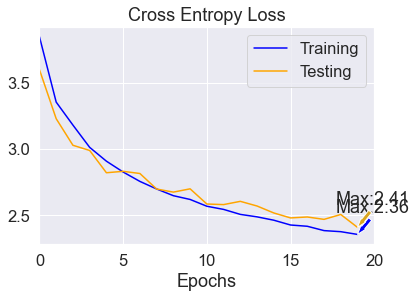

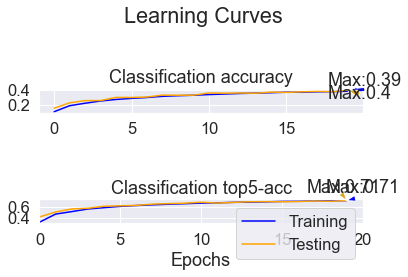

In [32]:
curves(history)

### Random Sample - Visualization

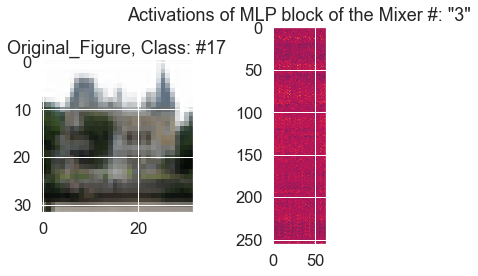

In [33]:
#Select a MixerBlock and visualize the activation
n_MixerLayer = 3
at_result = Mixer_Activations(example_prepro)
visualize_out(at_result,n_MixerLayer,num_example)

### Random Sample - Heatmap

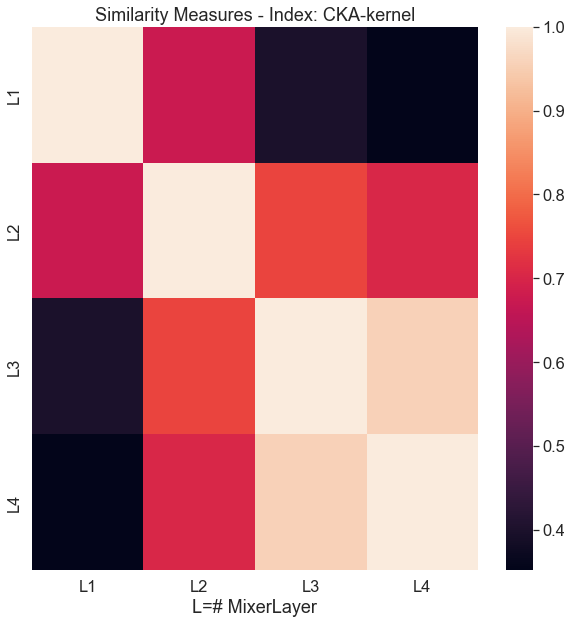

In [34]:
## Heatmap of activations of the random sample
at_heatmap_CKA_ran = Heatmap(at_result,'kernel')
visualize_Heatmap(at_heatmap_CKA_ran,'kernel',False)

### Batch - Heatmap

In [35]:
#Average of layer's activation
at_ave_mixer_activations = Prom_Mixer_Activations_Blocks(batch_prepro)
at_global_heatmap = Heatmap(at_ave_mixer_activations,'kernel')
visualize_Heatmap(at_global_heatmap,'kernel',False)

### Data distribution of Activations

In [ ]:
Distribution_Act_Layers(at_result,True)

# AT + BT

## Randon Sample

In [ ]:
annotation = True
dim = len(at_global_heatmap)
axis_labels = list()
for i in range(0,dim):
            axis_labels_inter = str('L%i'%(i+1))
            axis_labels.append(axis_labels_inter)
            
fig, (ax1, ax2)= plt.subplots(1,2)
ax1.set_title('Before Training')
sns.heatmap(bt_heatmap_CKA_ran, xticklabels=axis_labels, yticklabels=axis_labels, ax = ax1, annot= annotation)
ax2.set_title('After Training')
sns.heatmap(at_heatmap_CKA_ran, xticklabels=axis_labels, yticklabels=axis_labels, ax = ax2, annot= annotation)
sns.set(font_scale=1)
fig.set_tight_layout
fig.subplots_adjust(wspace=0.5)
fig.suptitle('CKA similarity - Sample #' + str(num_example))

## Batch

In [ ]:
annot = True
dim = len(at_global_heatmap)
axis_labels = list()
for i in range(0,dim):
            axis_labels_inter = str('L%i'%(i+1))
            axis_labels.append(axis_labels_inter)
            
fig, (ax1, ax2)= plt.subplots(1,2)
ax1.set_title('Before Training')
sns.heatmap(bt_global_heatmap, xticklabels=axis_labels, yticklabels=axis_labels, ax = ax1, annot= annotation)
ax2.set_title('After Training')
sns.heatmap(at_global_heatmap, xticklabels=axis_labels, yticklabels=axis_labels, ax = ax2, annot= annotation)
sns.set(font_scale=1)
fig.set_tight_layout
fig.subplots_adjust(wspace=0.3)
fig.suptitle('CKA similarity - Batch ' + str(batch_size) + ' images')